# Decoder Only Transformer

# **Steps of a Transformer**

---

## 🔹 Full Transformer Forward Pass

### **1. Embeddings**
Turn tokens (IDs) into vectors:

$$
H^{(0)} = \text{Embed}(\text{tokens}) + \text{PositionalEncodings}
$$

- `Embed(tokens)` = learned embedding lookup table (trainable).  
- `PositionalEncodings` = adds information about token order (fixed sinusoidal or learned).  

---

### **2. Repeated Transformer Blocks**

For each layer \( l = 1, …, L \):

1. **Normalize**  
$$
X = \text{LayerNorm}(H^{(l-1)})
$$

2. **Attention**  
$$
A = \text{MultiHeadAttention}(X)
$$  

Multi-head attention math:  

$$
Q = X W_Q, \quad K = X W_K, \quad V = X W_V
$$  

$$
\text{Attention}(Q,K,V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d}}\right)V
$$  

$$
\text{MHA}(X) = \text{Concat}(O_1, ..., O_h) W_O
$$

3. **Residual Connection**  
$$
H' = H^{(l-1)} + A
$$

4. **Normalize**  
$$
X = \text{LayerNorm}(H')
$$

5. **Feed-Forward Network (FFN)**  
$$
F = W_2 \, f(W_1 X + b_1) + b_2
$$  

6. **Residual Connection**  
$$
H^{(l)} = H' + F
$$

---

### **3. Final Hidden States**
After \(L\) layers:

$$
H^{(L)} \in \mathbb{R}^{T \times d}
$$

- Each row = final representation of one token.  
- \(T\) = number of tokens, \(d\) = hidden dimension.

---

### **4. Prediction Head**
Take the hidden state of the last token $h_T^{(L)}$:

$$
z = h_T^{(L)} W_{out} + b_{out}
$$

---

### **5. Softmax**
Convert logits \(z\) into probabilities for each vocab word:

$$
P(\text{next token}=v) = \frac{e^{z_v}}{\sum_j e^{z_j}}
$$

---

## 🔹 Plain English

1. Look up embeddings for each token, add position info.  
2. Send them through many transformer blocks (each block = normalize → attention → add back → normalize → feed-forward → add back).  
3. After the last block, you get the final “meaning vectors” for each token.  
4. Pick the last one, run it through a simple linear layer to turn it into scores for every word in the vocabulary.  
5. Apply softmax → probabilities for the next token.  

---

💡 **Key Notes**  
- The same equations are applied at each layer, but with different learned weights.  
- Attention = tokens “talk” to each other; FFN = tokens “think privately.”  
- Residuals ensure information flows through layers without vanishing.  
- During training, embeddings and all weights start random and are learned via backprop.

In [ ]:
# math-wise GPT, no fancy libs (just PyTorch)
import math, torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# tiny tokenizer (character-level for demo)
# ---------------------------
class CharTokenizer:
    def __init__(self, text):
        chars = sorted(list(set(text)))
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(chars)

    def encode(self, s):  # str -> list[int]
        return [self.stoi[ch] for ch in s]
    def decode(self, ids):  # list[int] -> str
        return "".join(self.itos[i] for i in ids)

# ---------------------------
# masked multi-head self-attention
# A = softmax((Q K^T)/sqrt(d_head)) V
# ---------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # learned projection matrices for Q, K, V, and output (W_Q, W_K, W_V, W_O)
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

        # causal mask (upper triangle = -inf so j>i is masked)
        mask = torch.triu(torch.ones(max_len, max_len), diagonal=1).bool()
        self.register_buffer("causal_mask", mask)  # shape (T,T), not a parameter

    def forward(self, H):  # H: (B, T, d_model)
        B, T, D = H.shape
        # projections
        Q = self.W_Q(H)  # (B, T, D)
        K = self.W_K(H)  # (B, T, D)
        V = self.W_V(H)  # (B, T, D)

        # split into heads: (B, T, n_heads, d_head) -> (B, n_heads, T, d_head)
        def split_heads(x):
            return x.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        # attention scores: (B, n_heads, T, T)
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_head)
        # apply causal mask so positions can only attend to <= current index
        scores = scores.masked_fill(self.causal_mask[:T, :T], float("-inf"))

        # attention weights
        A = F.softmax(scores, dim=-1)
        # weighted sum of values -> (B, n_heads, T, d_head)
        O = A @ V
        # concat heads -> (B, T, D)
        O = O.transpose(1, 2).contiguous().view(B, T, D)
        # final output projection
        return self.W_O(O)

# ---------------------------
# position-wise feed-forward network:
# FFN(x) = W2 f(W1 x + b1) + b2
# ---------------------------
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.W1 = nn.Linear(d_model, d_ff)
        self.W2 = nn.Linear(d_ff, d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        return self.drop(self.W2(self.act(self.W1(x))))

# ---------------------------
# one Transformer decoder block (Pre-LN):
# h1 = x + MHA(LN(x))
# h2 = h1 + FFN(LN(h1))
# ---------------------------
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, max_len, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)              # LayerNorm γ,β are learned params
        self.mha = MultiHeadSelfAttention(d_model, n_heads, max_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # attention sublayer + residual
        a = self.mha(self.ln1(x))
        x = x + self.drop(a)
        # feed-forward sublayer + residual
        f = self.ffn(self.ln2(x))
        x = x + self.drop(f)
        return x

# ---------------------------
# GPT (decoder-only transformer):
# H0 = Embed(tokens) + PosEmbed
# repeat blocks
# logits = LN(H_L) @ W_out  (weight-tying with token embeddings is common)
# ---------------------------
class TinyGPT(nn.Module):
    def __init__(self, vocab_size, max_len=256, d_model=256, n_layers=4, n_heads=4, d_ff=1024, dropout=0.0, tie_weights=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model

        # token & positional embeddings (learned parameters)
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed   = nn.Embedding(max_len, d_model)

        # stack of decoder blocks
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, max_len, dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # (optional) weight tying: W_out = token_embed^T
        if tie_weights:
            self.head.weight = self.token_embed.weight

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, idx, targets=None):
        """
        idx: (B, T) int token IDs
        targets: (B, T) next-token IDs for loss (optional)
        returns: logits (B, T, V) and loss if targets provided
        """
        B, T = idx.shape
        assert T <= self.max_len, "sequence too long"

        # embeddings + positions  -> H^(0)
        tok = self.token_embed(idx)                              # (B, T, d)
        pos = self.pos_embed(torch.arange(T, device=idx.device)) # (T, d)
        H = tok + pos                                           # (B, T, d)

        # pass through L decoder blocks
        for blk in self.blocks:
            H = blk(H)

        # final norm and output projection -> logits
        H = self.ln_f(H)                                        # (B, T, d)
        logits = self.head(H)                                   # (B, T, V)

        loss = None
        if targets is not None:
            # classic next-token loss: shift logits and targets by 1
            # predict x_{t+1} from hidden at position t
            logits_flat = logits[:, :-1, :].reshape(-1, self.vocab_size)
            targets_flat = targets[:, 1:].reshape(-1)
            loss = F.cross_entropy(logits_flat, targets_flat)
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=50, temperature=1.0, top_k=None):
        """
        Autoregressive generation (no KV cache for simplicity).
        idx: (B, T) current tokens
        """
        for _ in range(max_new_tokens):
            # crop to max_len from the right
            idx_cond = idx[:, -self.max_len:]
            logits, _ = self.forward(idx_cond)
            # take last time step's logits
            last_logits = logits[:, -1, :] / max(1e-6, temperature)

            if top_k is not None:
                # keep only top_k tokens
                v, ix = torch.topk(last_logits, top_k, dim=-1)
                out = torch.full_like(last_logits, float('-inf'))
                out.scatter_(dim=-1, index=ix, src=v)
                last_logits = out

            probs = F.softmax(last_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx


## Demo

In [ ]:
# 1) Build a toy dataset and tokenizer
corpus = (
    "Once upon a time there was a cat.\n"
    "The cat liked to sleep.\n"
    "The cat liked to eat.\n"
    "The cat was very happy.\n"
) * 200
text = "my head hurts a lot. my head hurts a little. my head hurts!\n"
tok = CharTokenizer(corpus)
ids = torch.tensor([tok.encode(corpus)], dtype=torch.long)  # (1, T)

# 2) Make the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyGPT(
    vocab_size=tok.vocab_size,
    max_len=128,
    d_model=256,
    n_layers=4,
    n_heads=4,
    d_ff=4*256,
    dropout=0.1,
    tie_weights=True
).to(device)

# 3) A super-mini "training" loop (just to show the loss goes down)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
model.train()
for step in range(200):
    idx = ids[:, :128].to(device)
    logits, loss = model(idx, targets=idx)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 50 == 0:
        print(f"step {step:4d}  loss {loss.item():.3f}")

# 4) Generate
model.eval()
ctx = "the cat was "
ctx_ids = torch.tensor([tok.encode(ctx)], dtype=torch.long, device=device)
gen_ids = model.generate(ctx_ids, max_new_tokens=50, temperature=0.9, top_k=tok.vocab_size - 1)
print(tok.decode(gen_ids[0].tolist()))

step    0  loss 3.245
step   50  loss 0.075
step  100  loss 0.034
step  150  loss 0.021
the cat was time there was a cat.
The cat liked tt sleep.
The 


## Numpy GPT Model

In [ ]:
# =========================
# Tiny GPT in pure JAX + Optax
# =========================
import math, functools, numpy as np
import jax
import jax.numpy as jnp
import optax

# -------------------------
# Tokenizer (character-level for simplicity)
# -------------------------
class CharTok:
    def __init__(self, text):
        vocab = sorted(set(text))
        self.stoi = {ch:i for i,ch in enumerate(vocab)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(vocab)
    def encode(self, s): return np.array([self.stoi[ch] for ch in s], dtype=np.int32)
    def decode(self, ids): return "".join(self.itos[int(i)] for i in ids)

# -------------------------
# Utility functions
# -------------------------
def gelu(x):
    return 0.5 * x * (1.0 + jnp.tanh(jnp.sqrt(2.0/jnp.pi) * (x + 0.044715 * x**3)))

def layernorm(x, gamma, beta, eps=1e-5):
    # normalize over last dim
    mu = jnp.mean(x, axis=-1, keepdims=True)
    var = jnp.mean((x - mu)**2, axis=-1, keepdims=True)
    y = (x - mu) / jnp.sqrt(var + eps)
    return y * gamma + beta

def causal_mask(T):
    # True where j > i (mask future), shape (1,1,T,T) to broadcast across batch/heads
    m = jnp.triu(jnp.ones((T, T), dtype=bool), k=1)
    return m[None, None, :, :]

# -------------------------
# Parameter initialization
# -------------------------
def normal_init(key, shape, std=0.02):
    return std * jax.random.normal(key, shape)

def init_params(rng, vocab_size, max_len, d_model, n_layers, n_heads, d_ff, tie_weights=True):
    keys = jax.random.split(rng, 3 + n_layers*8)
    k_tok, k_pos, k_out = keys[:3]
    idx = 3

    params = {}
    params['tok_embed'] = normal_init(k_tok,  (vocab_size, d_model))
    params['pos_embed'] = normal_init(k_pos,  (max_len,   d_model))

    params['blocks'] = []
    for _ in range(n_layers):
        kWQ, kWK, kWV, kWO = keys[idx:idx+4]; idx += 4
        kW1, kb1, kW2, kb2 = keys[idx:idx+4]; idx += 4

        block = {
            'ln1_g': jnp.ones((d_model,)),
            'ln1_b': jnp.zeros((d_model,)),
            'W_Q':   normal_init(kWQ, (d_model, d_model)),
            'W_K':   normal_init(kWK, (d_model, d_model)),
            'W_V':   normal_init(kWV, (d_model, d_model)),
            'W_O':   normal_init(kWO, (d_model, d_model)),
            'ln2_g': jnp.ones((d_model,)),
            'ln2_b': jnp.zeros((d_model,)),
            'W1':    normal_init(kW1, (d_model, d_ff)),
            'b1':    jnp.zeros((d_ff,)),
            'W2':    normal_init(kW2, (d_ff, d_model)),
            'b2':    jnp.zeros((d_model,))
        }
        params['blocks'].append(block)

    params['ln_f_g'] = jnp.ones((d_model,))
    params['ln_f_b'] = jnp.zeros((d_model,))
    W_out = normal_init(k_out, (d_model, vocab_size))
    if tie_weights:
        W_out = params['tok_embed'].T
    params['W_out'] = W_out
    return params

# -------------------------
# Multi-Head Self-Attention (masked)
# -------------------------
@functools.partial(jax.jit, static_argnames=('n_heads',))
def mha_forward(H, W_Q, W_K, W_V, W_O, n_heads, mask_4d):
    # H: (B, T, d), weights (d,d)
    B, T, d = H.shape
    d_head = d // n_heads

    Q = H @ W_Q  # (B,T,d)
    K = H @ W_K
    V = H @ W_V

    # reshape into heads: (B, h, T, d_head)
    def split_heads(x):
        x = x.reshape(B, T, n_heads, d_head)
        return jnp.transpose(x, (0, 2, 1, 3))
    Qh, Kh, Vh = split_heads(Q), split_heads(K), split_heads(V)

    # scores: (B, h, T, T)
    scores = jnp.einsum('bhtd,bhsd->bhts', Qh, Kh) / jnp.sqrt(d_head)

    # apply causal mask: set masked positions to very negative
    scores = jnp.where(mask_4d, jnp.full_like(scores, -1e9), scores)

    A = jax.nn.softmax(scores, axis=-1)        # (B,h,T,T)
    Oh = jnp.einsum('bhts,bhsd->bhtd', A, Vh)  # (B,h,T,d_head)

    # concat heads -> (B,T,d)
    O = jnp.transpose(Oh, (0, 2, 1, 3)).reshape(B, T, d)
    return O @ W_O  # output projection

# -------------------------
# Feed-Forward
# -------------------------
def ffn_forward(X, W1, b1, W2, b2):
    return (gelu(X @ W1 + b1)) @ W2 + b2

# -------------------------
# One decoder block (Pre-LN): x + MHA(LN(x)) ; x + FFN(LN(x))
# -------------------------
@functools.partial(jax.jit, static_argnames=('n_heads',))
def decoder_block_forward(H, block, n_heads, mask_4d):
    # LN -> MHA -> Residual
    X = layernorm(H, block['ln1_g'], block['ln1_b'])
    A = mha_forward(X, block['W_Q'], block['W_K'], block['W_V'], block['W_O'], n_heads, mask_4d)
    H = H + A
    # LN -> FFN -> Residual
    X = layernorm(H, block['ln2_g'], block['ln2_b'])
    F = ffn_forward(X, block['W1'], block['b1'], block['W2'], block['b2'])
    H = H + F
    return H

# -------------------------
# Model forward
# -------------------------
@functools.partial(jax.jit, static_argnames=('n_heads',))
def forward_logits(params, tokens, n_heads):
    """
    tokens: (B,T) int32
    returns: logits (B,T,V), final hidden (B,T,d)
    """
    B, T = tokens.shape
    d = params['tok_embed'].shape[1]
    V = params['W_out'].shape[1]
    # embeddings + positions
    tok = params['tok_embed'][tokens]                 # (B,T,d)
    pos = params['pos_embed'][jnp.arange(T)]          # (T,d)
    H = tok + pos                                     # (B,T,d)

    # causal mask for attention, broadcast over (B,h)
    m4d = causal_mask(T)

    # transformer blocks
    for block in params['blocks']:
        H = decoder_block_forward(H, block, n_heads, m4d)

    # final norm + output projection
    Hf = layernorm(H, params['ln_f_g'], params['ln_f_b'])  # (B,T,d)
    logits = jnp.einsum('btd,dv->btv', Hf, params['W_out'])  # (B,T,V)
    return logits, Hf

# -------------------------
# Loss (next-token cross-entropy, shift by 1)
# -------------------------
def next_token_loss(params, tokens, n_heads):
    logits, _ = forward_logits(params, tokens, n_heads)  # (B,T,V)
    # predict x_t from position t-1
    logits = logits[:, :-1, :]             # (B,T-1,V)
    targets = tokens[:, 1:]                # (B,T-1)

    logprobs = jax.nn.log_softmax(logits, axis=-1)
    nll = -jnp.take_along_axis(logprobs, targets[..., None], axis=-1).squeeze(-1)  # (B,T-1)
    return nll.mean()

# -------------------------
# Training step (Optax AdamW)
# -------------------------
@functools.partial(jax.jit, static_argnames=('n_heads', 'optimizer'))
def train_step(params, opt_state, batch_tokens, n_heads, optimizer):
    loss_fn = lambda p: next_token_loss(p, batch_tokens, n_heads)
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# -------------------------
# Simple data batching
# -------------------------
def make_batches(ids, seq_len, batch_size, steps, rng):
    N = len(ids)
    for _ in range(steps):
        starts = jax.random.randint(rng, (batch_size,), 0, max(1, N-seq_len-1))
        batch = np.stack([ids[s:s+seq_len] for s in np.array(starts)], axis=0)  # (B,T)
        yield batch.astype(np.int32)

# -------------------------
# Autoregressive generation
# -------------------------
@functools.partial(jax.jit, static_argnames=('n_heads',))
def last_step_probs(params, tokens, n_heads, temperature=1.0):
    logits, _ = forward_logits(params, tokens, n_heads)   # (B,T,V)
    last = logits[:, -1, :] / temperature
    return jax.nn.softmax(last, axis=-1)                  # (B,V)

def generate(params, prefix_ids, n_heads, max_new_tokens, temperature=1.0, top_k=None, key=None, max_len=256):
    ids = list(prefix_ids)
    key = jax.random.PRNGKey(0) if key is None else key
    for _ in range(max_new_tokens):
        ctx = np.array(ids[-max_len:], dtype=np.int32)[None, :]  # (1,T)
        probs = np.array(last_step_probs(params, ctx, n_heads, temperature))[0]  # (V,)
        if top_k is not None:
            # Ensure top_k is within bounds of the vocabulary size
            actual_top_k = min(top_k, probs.shape[0] - 1)
            if actual_top_k < 1: # Handle the case where top_k is 0 or 1 and vocab is small
                 actual_top_k = 1
            top_idx = np.argpartition(-probs, actual_top_k)[:actual_top_k]
            mask = np.ones_like(probs, dtype=bool)
            mask[top_idx] = False
            probs = np.where(mask, 0.0, probs)
            probs = probs / probs.sum()
        key, sk = jax.random.split(key)
        nxt = int(jax.random.choice(sk, probs.shape[0], p=probs))
        ids.append(nxt)
    return ids

# =========================
# Demo run
# =========================
# Tiny repetitive corpus (learns quickly)
corpus = (
    "Once upon a time there was a cat.\n"
    "The cat liked to sleep.\n"
    "The cat liked to eat.\n"
    "The cat was very happy.\n"
) * 200
tok = CharTok(corpus)
ids = tok.encode(corpus)

# Model/config
max_len   = 128
d_model   = 192
n_layers  = 3
n_heads   = 3
d_ff      = 4 * d_model
vocab     = tok.vocab_size
tie_out   = True

rng = jax.random.PRNGKey(42)
params = init_params(rng, vocab, max_len, d_model, n_layers, n_heads, d_ff, tie_weights=tie_out)

# Optimizer
lr = 3e-4
weight_decay = 0.01
optimizer = optax.adamw(lr, weight_decay=weight_decay)
opt_state = optimizer.init(params) # Initialize optimizer state here

# Training loop (few steps just to see loss drop)
seq_len   = 128
batch_sz  = 32
steps     = 400
data_rng  = jax.random.PRNGKey(123)

for i, batch in enumerate(make_batches(ids, seq_len, batch_sz, steps, data_rng)):
    params, opt_state, loss = train_step(params, opt_state, batch, n_heads, optimizer)
    if i % 50 == 0:
        print(f"step {i:4d}  loss {float(loss):.4f}")

# Generate
prefix = "The cat "
gen_ids = generate(params, tok.encode(prefix), n_heads, max_new_tokens=100, temperature=0.9, top_k=40, key=jax.random.PRNGKey(7), max_len=max_len)
print(tok.decode(gen_ids))

step    0  loss 3.1981
step   50  loss 0.5930
step  100  loss 0.0727
step  150  loss 0.0285
step  200  loss 0.0197
step  250  loss 0.0157
step  300  loss 0.0135
step  350  loss 0.0120
The cat was very happy.
Once upon a time there was a cat.
The cat liked to sleep.
The cat liked to eat.
The 


##Torch Multi Token Prediction

In [ ]:
# ============================
# TinyGPT_MTP: multi-token heads
# ============================
import math, torch
import torch.nn as nn
import torch.nn.functional as F

# (Reuses your CharTokenizer, MultiHeadSelfAttention, FeedForward, DecoderBlock)

class TinyGPT_MTP(nn.Module):
    """
    Decoder-only GPT with Multi-Token Prediction (MTP) heads.

    n_out_heads: number of parallel output heads (k=1..n), where head-k predicts x_{t+k}
    lambda_weights: optional list/tuple/tensor of length n_out_heads with per-head loss weights
                    (default = uniform weights = 1.0 for each head)
    tie_first_head: if True, tie head-1 weights to token embeddings (classic weight tying).
                    Other heads remain independent.
    """
    def __init__(
        self,
        vocab_size,
        max_len=256,
        d_model=256,
        n_layers=4,
        n_heads=4,
        d_ff=1024,
        dropout=0.0,
        n_out_heads=3,
        lambda_weights=None,
        tie_first_head=True,
    ):
        super().__init__()
        assert n_out_heads >= 1
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_out_heads = n_out_heads

        # token & positional embeddings (learned)
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed   = nn.Embedding(max_len, d_model)

        # transformer blocks
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, max_len, dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)

        # multiple output heads (each: d_model -> vocab)
        self.heads = nn.ModuleList([
            nn.Linear(d_model, vocab_size, bias=False) for _ in range(n_out_heads)
        ])

        # optional weight tying for the *first* (1-ahead) head
        if tie_first_head:
            self.heads[0].weight = self.token_embed.weight

        # per-head loss weights
        if lambda_weights is None:
            lambda_weights = [1.0] * n_out_heads
        assert len(lambda_weights) == n_out_heads
        self.register_buffer(
            "_lambda_weights",
            torch.tensor(lambda_weights, dtype=torch.float32)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, idx, targets=None, return_all_logits=False):
        """
        idx:      (B, T) int token IDs
        targets:  (B, T) int token IDs (optional). If provided, compute summed MTP loss.
        return_all_logits: if True, return list of logits per head; else just head-1 logits.

        Returns:
          - logits (B, T, V) for head-1 if return_all_logits=False
            OR a list [logits_k] of length n_out_heads if True (each (B,T,V))
          - loss (scalar) if targets provided, else None
        """
        B, T = idx.shape
        assert T <= self.max_len, "sequence too long"

        # embeddings + positions
        tok = self.token_embed(idx)                               # (B, T, d)
        pos = self.pos_embed(torch.arange(T, device=idx.device))  # (T, d)
        H = tok + pos                                             # (B, T, d)

        # transformer blocks
        for blk in self.blocks:
            H = blk(H)

        # final norm
        H = self.ln_f(H)  # (B, T, d)

        # compute logits for each head
        logits_all = [head(H) for head in self.heads]  # list of (B, T, V)

        loss = None
        if targets is not None:
            # Sum cross-entropy over k=1..n_out_heads
            total = 0.0
            for k, logits_k in enumerate(logits_all, start=1):
                # head-k predicts x_{t+k} from position t => align:
                # logits_k[:, :-k, :] vs targets[:, k:]
                if T - k <= 0:
                    continue  # not enough context; skip if sequence is too short
                L = logits_k[:, :-k, :].reshape(-1, self.vocab_size)
                Y = targets[:, k:].reshape(-1)
                ce = F.cross_entropy(L, Y)
                total = total + self._lambda_weights[k-1] * ce
            loss = total

        if return_all_logits:
            return logits_all, loss
        else:
            # default: return head-1 logits (standard next-token)
            return logits_all[0], loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=50, temperature=1.0, top_k=None, use_head_k=1):
        """
        Standard autoregressive generation. By default uses head-1 (next-token head).
        You can set use_head_k>1 to experiment, but typical decoding uses k=1.

        idx: (B, T) current tokens
        """
        assert 1 <= use_head_k <= self.n_out_heads
        head_ix = use_head_k - 1

        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.max_len:]
            # get logits for the chosen head only (avoid extra compute)
            tok = self.token_embed(idx_cond)
            T = idx_cond.size(1)
            pos = self.pos_embed(torch.arange(T, device=idx.device))
            H = tok + pos
            for blk in self.blocks:
                H = blk(H)
            H = self.ln_f(H)
            last_logits = self.heads[head_ix](H)[:, -1, :] / max(1e-6, temperature)

            if top_k is not None:
                v, ix = torch.topk(last_logits, top_k, dim=-1)
                out = torch.full_like(last_logits, float('-inf'))
                out.scatter_(dim=-1, index=ix, src=v)
                last_logits = out

            probs = F.softmax(last_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx


## Demo

In [ ]:
# Build toy data
text = ("The cat likes to nap.\nThe cat likes to eat.\n") * 200
tok = CharTokenizer(text)
ids = torch.tensor([tok.encode(text)], dtype=torch.long)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create MTP model: 3 heads (predict 1, 2, and 3 steps ahead)
model = TinyGPT_MTP(
    vocab_size=tok.vocab_size,
    max_len=128,
    d_model=256,
    n_layers=4,
    n_heads=4,
    d_ff=4*256,
    dropout=0.1,
    n_out_heads=3,
    lambda_weights=[1.0, 1.0, 1.0],   # equal weighting
    tie_first_head=True
).to(device)

# Quick training loop (end-to-end) – identical to standard, just use returned loss
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
model.train()
for step in range(200):
    batch = ids[:, :128].to(device)   # one batch for demo
    _, loss = model(batch, targets=batch)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if step % 50 == 0:
        print(f"step {step:4d}  mtp_loss {loss.item():.3f}")

# Generate with the standard head-1 (next-token head)
model.eval()
ctx = torch.tensor([tok.encode("The cat ")], dtype=torch.long, device=device)
out = model.generate(ctx, max_new_tokens=60, temperature=0.8, top_k=min(40, tok.vocab_size - 1), use_head_k=1)
print(tok.decode(out[0].tolist()))

step    0  mtp_loss 8.524
step   50  mtp_loss 0.523
step  100  mtp_loss 0.193
step  150  mtp_loss 0.105
The cat likes to nap.
The cat likes to eanat likes t to nato nap.
Th


## Make a corpus of mobile app reviews

In [ ]:
import pandas as pd

df = pd.read_csv("multilingual_mobile_app_reviews_2025.csv")

texts = (
    df["review_text"]
      .dropna()
      .astype(str)
      .map(str.strip)
      .tolist()
)

SEP = "\n<REVIEW>\n"
corpus = SEP.join(texts)


In [ ]:
corpus

"Qui doloribus consequuntur. Perspiciatis tempora assumenda in. Atque doloremque nobis.\n<REVIEW>\nGreat app but too many ads, consider premium version.\n<REVIEW>\nThe interface could be better but overall good experience.\n<REVIEW>\nLatest update broke some features, please fix soon.\n<REVIEW>\nPerfect for daily use, highly recommend to everyone.\n<REVIEW>\nWorks perfectly on my device, no complaints at all.\n<REVIEW>\nBasso bello società paese. Quello mostrare verso.\n<REVIEW>\nOdcinek skład zarówno zgodnie zaś. Powoli gdyby gleba.\n<REVIEW>\nEius odio facilis fuga distinctio eaque. Non cupiditate quas cum. Earum unde porro dolor eveniet quisquam.\n<REVIEW>\nHusband at tree note responsibility defense.\n<REVIEW>\nWorks perfectly on my device, no complaints at all.\n<REVIEW>\nThe interface could be better but overall good experience.\n<REVIEW>\nWorks perfectly on my device, no complaints at all.\n<REVIEW>\nSome bugs need fixing but generally satisfied with it.\n<REVIEW>\nLatest update

In [ ]:
tok = CharTokenizer(corpus)
ids = torch.tensor([tok.encode(corpus)], dtype=torch.long)  # shape (1, T)


In [ ]:
def make_batches(ids_1xT, seq_len=256, batch_size=16, steps=1000):
    full = ids_1xT[0]
    Ttot = full.size(0)
    for _ in range(steps):
        starts = torch.randint(0, Ttot - seq_len - 1, (batch_size,))
        batch = torch.stack([full[s:s+seq_len] for s in starts], dim=0)
        yield batch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyGPT(vocab_size=tok.vocab_size).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)

for step, batch in enumerate(make_batches(ids, seq_len=256, batch_size=32, steps=400)):
    batch = batch.to(device)
    _, loss = model(batch, targets=batch)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 50 == 0:
        print(f"step {step} | loss {loss.item():.3f}")


step 0 | loss 6.627
step 50 | loss 2.646
step 100 | loss 2.341
step 150 | loss 2.031
step 200 | loss 1.415
step 250 | loss 1.029
step 300 | loss 0.945
step 350 | loss 0.861


In [ ]:
model.eval()
ctx = "I love "
x = torch.tensor([tok.encode(ctx)], dtype=torch.long, device=device)
y = model.generate(x, max_new_tokens=120, temperature=0.9, top_k=40)
print(tok.decode(y[0].tolist()))


I love taneree pence desoon derio mpolibiance. Quas dinila gere dizengentibuti wiedit.
<REVIEW>
Some bugs need fixing but gener


## Math Heavy Implementation for Clarity

In [ ]:
# ============================================================
# TinyMathGPT — a from-scratch, math-first GPT (PyTorch)
# ------------------------------------------------------------
# Goal: make each step of the Transformer obvious:
#  - clear function/class names
#  - explicit shapes on inputs/outputs
#  - comments that tie code to the math equations
#
# Notation used below:
#   B = batch size
#   T = sequence length (# tokens)
#   V = vocabulary size
#   d = hidden dimension (aka d_model)
#   h = # attention heads
#   d_head = d // h
# ============================================================

import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# ------------------------------------------------------------
# 0) A tiny character-level tokenizer for demos
# ------------------------------------------------------------
class CharTokenizer:
    """
    Converts strings to integer token IDs and back, using one token per character.
    """
    def __init__(self, text: str):
        chars = sorted(list(set(text)))
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(chars)

    def encode(self, s: str) -> list[int]:
        return [self.stoi[ch] for ch in s]

    def decode(self, ids: list[int]) -> str:
        return "".join(self.itos[i] for i in ids)


# ------------------------------------------------------------
# 1) Masked Multi-Head Self-Attention
# ------------------------------------------------------------
class MaskedMultiHeadSelfAttention(nn.Module):
    """
    Implements: softmax( (Q K^T) / sqrt(d_head) ) @ V  with a causal (look-back-only) mask.

    Input:
      H: (B, T, d)  -- hidden states from previous layer

    Trainable parameters (per layer):
      W_Q, W_K, W_V: (d, d)  -- project H->Q, H->K, H->V
      W_O:           (d, d)  -- final output projection (concat heads -> d, then project)

    Output:
      out: (B, T, d)
    """
    def __init__(self, d_model: int, num_heads: int, max_seq_len: int):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        # Linear projections for Q, K, V, and output (no bias for clarity)
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)

        # Causal mask: disallow attention from position i to future positions j>i
        # Shape: (T, T) with True above main diagonal
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer("causal_mask_TT", mask)  # non-parameter buffer

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, d) -> (B, h, T, d_head)
        We simply reshape and permute to view the 'head' axis separately.
        """
        B, T, d = x.shape
        x = x.view(B, T, self.num_heads, self.d_head)   # (B, T, h, d_head)
        x = x.transpose(1, 2)                           # (B, h, T, d_head)
        return x

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, h, T, d_head) -> (B, T, d)
        """
        B, h, T, d_head = x.shape
        x = x.transpose(1, 2).contiguous()              # (B, T, h, d_head)
        x = x.view(B, T, h * d_head)                    # (B, T, d)
        return x

    def forward(self, H: torch.Tensor) -> torch.Tensor:
        """
        H: (B, T, d)
        returns: (B, T, d)
        """
        B, T, d = H.shape

        # 1) Linear projections to queries, keys, values
        #    Q = H W_Q ; K = H W_K ; V = H W_V
        Q = self.W_Q(H)  # (B, T, d)
        K = self.W_K(H)  # (B, T, d)
        V = self.W_V(H)  # (B, T, d)

        # 2) Split into heads: (B, T, d) -> (B, h, T, d_head)
        Q = self._split_heads(Q)
        K = self._split_heads(K)
        V = self._split_heads(V)

        # 3) Scaled dot-product attention per head
        #    scores = (Q @ K^T) / sqrt(d_head)  -> (B, h, T, T)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_head)

        # 4) Apply causal mask so token i cannot see future tokens j>i
        scores = scores.masked_fill(self.causal_mask_TT[:T, :T], float("-inf"))

        # 5) Convert scores to attention weights with softmax along last dim (over "keys")
        weights = F.softmax(scores, dim=-1)  # (B, h, T, T)

        # 6) Weighted sum of values: (B, h, T, T) @ (B, h, T, d_head) -> (B, h, T, d_head)
        heads_out = weights @ V

        # 7) Re-combine heads and apply output projection W_O
        concat = self._combine_heads(heads_out)  # (B, T, d)
        out = self.W_O(concat)                   # (B, T, d)
        return out


# ------------------------------------------------------------
# 2) Position-wise Feed-Forward Network (FFN)
# ------------------------------------------------------------
class PositionwiseFeedForward(nn.Module):
    """
    Implements: FFN(x) = W2 * GELU(W1 * x + b1) + b2 (independently at each position)

    Input:
      X: (B, T, d)

    Trainable parameters (per layer):
      W1: (d, d_ff), b1: (d_ff,)
      W2: (d_ff, d), b2: (d,)

    Output:
      Y: (B, T, d)
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.W1 = nn.Linear(d_model, d_ff)
        self.W2 = nn.Linear(d_ff, d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.drop(self.W2(self.act(self.W1(X))))


# ------------------------------------------------------------
# 3) One Decoder Block (Pre-LayerNorm variant)
# ------------------------------------------------------------
class DecoderBlock(nn.Module):
    """
    One Transformer decoder block (Pre-LN):
       A) X1 = LayerNorm(H)
          A  = SelfAttention(X1)
          H  = H + A                  # residual add

       B) X2 = LayerNorm(H)
          F  = FFN(X2)
          H  = H + F                  # residual add

    Input/Output:
      H: (B, T, d)
    """
    def __init__(self, d_model: int, num_heads: int, d_ff: int, max_seq_len: int, dropout: float = 0.0):
        super().__init__()
        self.norm_before_attn = nn.LayerNorm(d_model)
        self.self_attn = MaskedMultiHeadSelfAttention(d_model, num_heads, max_seq_len)
        self.norm_before_ffn = nn.LayerNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, H: torch.Tensor) -> torch.Tensor:
        # --- Attention sub-layer ---
        X1 = self.norm_before_attn(H)  # (B, T, d)
        A  = self.self_attn(X1)        # (B, T, d)
        H  = H + self.drop(A)          # residual

        # --- FFN sub-layer ---
        X2 = self.norm_before_ffn(H)   # (B, T, d)
        F  = self.ffn(X2)              # (B, T, d)
        H  = H + self.drop(F)          # residual
        return H


# ------------------------------------------------------------
# 4) TinyMathGPT — full decoder-only Transformer
# ------------------------------------------------------------
class TinyMathGPT(nn.Module):
    """
    GPT-style (decoder-only) language model:

      H^(0) = TokenEmbedding(tokens) + PositionalEmbedding(positions)
      Repeat L times:
        H = DecoderBlock(H)    # Pre-LN: LN -> MHA -> +res -> LN -> FFN -> +res
      H^*   = LayerNorm(H)
      Logits = H^* @ W_out

    Training loss (next-token prediction):
      predict x_{t+1} from hidden at t (shifted cross-entropy)

    Inputs:
      idx:     (B, T) int token IDs
      targets: (B, T) int token IDs (optional; if provided, compute loss)

    Outputs:
      logits: (B, T, V)
      loss:   scalar (if targets provided)
    """
    def __init__(
        self,
        vocab_size: int,
        max_seq_len: int = 256,
        d_model: int = 256,
        num_layers: int = 4,
        num_heads: int = 4,
        d_ff: int = 1024,
        dropout: float = 0.0,
        tie_weights: bool = True
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        # (a) Token + Positional embeddings
        # TokenEmbedding: (V, d), PosEmbedding: (T_max, d)
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed   = nn.Embedding(max_seq_len, d_model)

        # (b) Stack of decoder blocks
        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, max_seq_len, dropout=dropout)
            for _ in range(num_layers)
        ])

        # (c) Final norm + output projection to vocab logits
        self.final_norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, vocab_size, bias=False)

        # (optional) Weight tying: W_out = token_embed^T
        if tie_weights:
            self.output_head.weight = self.token_embed.weight

        # init weights (simple normal init)
        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module):
        if isinstance(m, (nn.Linear, nn.Embedding)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor | None = None):
        """
        Forward pass (training/eval).

        idx:     (B, T) int token IDs
        targets: (B, T) int token IDs (optional for loss)

        returns: (logits, loss)
          logits: (B, T, V)
          loss:   scalar or None
        """
        B, T = idx.shape
        assert T <= self.max_seq_len, f"sequence too long: T={T} > max_seq_len={self.max_seq_len}"

        # ----- Embeddings -----
        # Token embeddings: (B, T, d)
        tok_emb: torch.Tensor = self.token_embed(idx)
        # Positional embeddings: (T, d) -> broadcast to (B, T, d)
        pos_ids = torch.arange(T, device=idx.device)
        pos_emb: torch.Tensor = self.pos_embed(pos_ids)
        H = tok_emb + pos_emb  # (B, T, d) == H^(0)

        # ----- Transformer Blocks -----
        for block in self.blocks:
            H = block(H)  # (B, T, d)

        # ----- Final norm + Output head -----
        H_star = self.final_norm(H)           # (B, T, d)
        logits = self.output_head(H_star)     # (B, T, V)

        # ----- Next-token prediction loss (shifted by 1) -----
        loss = None
        if targets is not None:
            # predict x_{t+1} using hidden at t
            # align logits[:, :-1, :] with targets[:, 1:]
            logits_flat = logits[:, :-1, :].reshape(-1, self.vocab_size)  # ((B*(T-1)), V)
            targets_flat = targets[:, 1:].reshape(-1)                     # ((B*(T-1)),)
            loss = F.cross_entropy(logits_flat, targets_flat)

        return logits, loss

    @torch.no_grad()
    def generate(
        self,
        idx: torch.Tensor,
        max_new_tokens: int = 50,
        temperature: float = 1.0,
        top_k: int | None = None
    ) -> torch.Tensor:
        """
        Autoregressive generation: repeatedly predict the next token and append.

        idx: (B, T_start) int token IDs
        returns: (B, T_start + max_new_tokens) int token IDs
        """
        for _ in range(max_new_tokens):
            # Only feed the last max_seq_len tokens to respect positional table
            idx_cond = idx[:, -self.max_seq_len:]

            # Forward pass to get logits over vocab for each time step
            logits, _ = self.forward(idx_cond)  # logits: (B, T_cond, V)

            # Take the logits at the last time step
            next_token_logits = logits[:, -1, :] / max(1e-6, temperature)  # (B, V)

            # Optional top-k truncation (keep only top_k logits)
            if top_k is not None:
                v, ix = torch.topk(next_token_logits, top_k, dim=-1)
                filtered = torch.full_like(next_token_logits, float("-inf"))
                filtered.scatter_(dim=-1, index=ix, src=v)
                next_token_logits = filtered

            # Convert to probabilities and sample
            probs = F.softmax(next_token_logits, dim=-1)  # (B, V)
            next_id = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append the new token
            idx = torch.cat([idx, next_id], dim=1)  # (B, T+1)
        return idx


# Multi-headed future token predictor (3 heads)

vanilla gpt 2 model
removed softmax prediction head. froze trunk. then added multiple multi future token prediction heads and trained only those.

In [ ]:
# ====== minimal installs ======
!pip -q install transformers datasets torch

# ====== imports ======
import math, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Dict, Tuple
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ====== data: small & simple (WikiText-2 raw) ======
raw = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad; use EOS

MAX_LEN = 256

def tokenize_fn(ex):
    # Fixed length => no ragged batches; attention_mask marks real tokens.
    return tokenizer(
        ex["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )

tok_train = raw["train"].map(tokenize_fn, batched=True, remove_columns=raw["train"].column_names)
tok_val   = raw["validation"].map(tokenize_fn, batched=True, remove_columns=raw["validation"].column_names)


@dataclass
class CausalBatch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor

def collate(batch):
    return CausalBatch(
        input_ids=torch.tensor([b["input_ids"] for b in batch], dtype=torch.long),
        attention_mask=torch.tensor([b["attention_mask"] for b in batch], dtype=torch.long),
    )

# small slices for speed; increase for better signal
train_loader = DataLoader(tok_train.select(range(4000)), batch_size=8, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(tok_val.select(range(1000)),  batch_size=8, shuffle=False, collate_fn=collate)

# ====== model: load GPT-2, freeze trunk, add auxiliary heads (t+1, t+2, t+3) ======
base_name = "gpt2"
cfg = AutoConfig.from_pretrained(base_name, output_hidden_states=False)  # last_hidden_state is sufficient
model = AutoModelForCausalLM.from_pretrained(base_name, config=cfg).to(device)
vocab_size = model.config.vocab_size
hidden_size = model.transformer.wte.embedding_dim  # 768 for gpt2

# freeze all pretrained params
for p in model.parameters():
    p.requires_grad_(False)

class OffsetHeads(nn.Module):
    """
    Simple linear heads that read from the final hidden state at position t
    and predict tokens at offsets t+1, t+2, t+3.
    """
    def __init__(self, hidden_size: int, vocab_size: int, offsets=(1,2,3)):
        super().__init__()
        self.offsets = list(offsets)
        self.heads = nn.ModuleDict({str(k): nn.Linear(hidden_size, vocab_size) for k in self.offsets})

    def forward(self, H: torch.Tensor, attn_mask: torch.Tensor) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
        """
        H: (B, T, d) final hidden states from GPT-2 transformer
        attn_mask: (B, T)
        Returns dict: k -> (logits_k, mask_k),
          where logits_k shape is (B, T-k, V) aligned to predict x_{t+k} from H_t
        """
        B, T, D = H.shape
        out = {}
        for k in self.offsets:
            head = self.heads[str(k)]
            # valid source positions t: 0..T-k-1
            logits = head(H[:, :-k, :])                # (B, T-k, V)
            # mask requires both source pos and target pos to be valid:
            mask = (attn_mask[:, :-k] & attn_mask[:, k:])  # (B, T-k)
            out[k] = (logits, mask)
        return out

aux = OffsetHeads(hidden_size, vocab_size, offsets=(1,2,3)).to(device)
optim = torch.optim.AdamW(aux.parameters(), lr=5e-4)

# ====== helpers: loss/metrics for aux heads ======
def offset_loss_and_metrics(offset_logits_mask, targets):
    """
    offset_logits_mask: dict k -> (logits, mask)
      logits: (B, T-k, V)
      mask:   (B, T-k)
    targets: (B, T) token ids
    Returns total_loss, details[k] = {"loss", "acc@1", "n_tokens"}
    """
    total = 0.0
    details = {}
    for k, (logits, mask) in offset_logits_mask.items():
        tgt = targets[:, k:]                          # (B, T-k)
        B, Tk, V = logits.shape
        m = mask.bool().view(-1)
        if m.sum().item() == 0:
            details[k] = {"loss": 0.0, "acc@1": 0.0, "n_tokens": 0}
            continue
        logits_f = logits.reshape(-1, V)[m]           # (N, V)
        tgt_f    = tgt.reshape(-1)[m]                 # (N,)
        loss = F.cross_entropy(logits_f, tgt_f)
        with torch.no_grad():
            pred = logits_f.argmax(-1)
            acc = (pred == tgt_f).float().mean().item()
        total = total + loss
        details[k] = {"loss": float(loss.item()), "acc@1": acc, "n_tokens": int(m.sum().item())}
    return total, details

@torch.no_grad()
def eval_aux(aux, model, loader):
    model.eval(); aux.eval()
    agg = {1: {"loss_sum":0.0,"correct":0,"count":0},
           2: {"loss_sum":0.0,"correct":0,"count":0},
           3: {"loss_sum":0.0,"correct":0,"count":0}}
    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) < 4:  # needs at least 4 to compute up to k=3
            continue
        # get final hidden states without running lm_head
        H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)
        off = aux(H, attn)
        loss, detail = offset_loss_and_metrics(off, inp)
        for k, d in detail.items():
            n = d["n_tokens"]
            agg[k]["loss_sum"] += d["loss"] * n
            agg[k]["correct"]  += int(d["acc@1"] * n)
            agg[k]["count"]    += n
    out = {}
    for k in agg:
        cnt = max(1, agg[k]["count"])
        out[k] = {"loss": agg[k]["loss_sum"]/cnt,
                  "acc@1": agg[k]["correct"]/cnt,
                  "count": agg[k]["count"]}
    return out

# ====== baseline: vanilla GPT-2 for t+1, t+2, t+3 (teacher forcing) ======
@torch.no_grad()
@torch.no_grad()
def eval_vanilla(model, loader):
    """
    Baseline scores for offsets k=1,2,3 using the standard next-token head.
    For each k, we score target x_{t+k} using logits at positions (t + k - 1).
    Shapes are aligned so time length is always T - k.
    """
    model.eval()

    def summarize(logits_k, tgt_k, mask_k):
        m = mask_k.bool().view(-1)
        if m.sum().item() == 0:
            return 0.0, 0.0, 0
        logits_f = logits_k.reshape(-1, logits_k.size(-1))[m]
        tgt_f    = tgt_k.reshape(-1)[m]
        L = F.cross_entropy(logits_f, tgt_f)
        pred = logits_f.argmax(-1)
        acc = (pred == tgt_f).float().mean().item()
        return float(L.item()), acc, int(m.sum().item())

    agg = {1: {"loss_sum":0.0,"correct":0,"count":0},
           2: {"loss_sum":0.0,"correct":0,"count":0},
           3: {"loss_sum":0.0,"correct":0,"count":0}}

    for batch in loader:
        inp  = batch.input_ids.to(device)        # (B, T)
        attn = batch.attention_mask.to(device)   # (B, T)
        out  = model(input_ids=inp, attention_mask=attn)
        logits = out.logits                      # (B, T, V)
        B, T, V = logits.shape

        # handle each offset uniformly
        for k in (1, 2, 3):
            if T <= k:  # not enough time steps to score this offset
                continue
            # logits at positions (t + k - 1), truncated to length T - k
            # Using end index -1 keeps length aligned with tgt (T - k)
            start = k - 1
            logits_k = logits[:, start:-1, :]         # (B, T-k, V)
            tgt_k    = inp[:, k:]                     # (B, T-k)
            mask_k   = attn[:, start:-1] & attn[:, k:]# (B, T-k)

            L, A, N = summarize(logits_k, tgt_k, mask_k)
            agg[k]["loss_sum"] += L * N
            agg[k]["correct"]  += int(A * N)
            agg[k]["count"]    += N

    out = {}
    for k in (1, 2, 3):
        cnt = max(1, agg[k]["count"])
        out[k] = {
            "loss": agg[k]["loss_sum"]/cnt,
            "acc@1": agg[k]["correct"]/cnt,
            "count": agg[k]["count"],
        }
    return out

# ====== training loop: train ONLY the aux heads ======
def train_epoch(model, aux, loader, optim):
    model.eval()   # trunk frozen
    aux.train()
    running = 0.0
    steps = 0
    for steps, batch in enumerate(loader, 1):
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)

        with torch.no_grad():
            H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state

        off = aux(H, attn)
        loss, detail = offset_loss_and_metrics(off, inp)

        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()

        running += float(loss.item())
        if steps % 100 == 0:
            print(f"step {steps:4d} | loss={loss.item():.3f} | details={detail}")
    return running / max(1, steps)

# ====== run: baseline -> train -> compare ======
print(">>> Baseline (vanilla GPT-2)")
base = eval_vanilla(model, val_loader)
for k in sorted(base):
    print(f"vanilla k=+{k}: acc@1={base[k]['acc@1']:.3f}, loss={base[k]['loss']:.3f}, N={base[k]['count']}")

print("\n>>> Train aux heads (frozen trunk)")
EPOCHS = 2  # bump to 3–5 for better signal
for e in range(1, EPOCHS+1):
    tr_loss = train_epoch(model, aux, train_loader, optim)
    metrics = eval_aux(aux, model, val_loader)
    print(f"[epoch {e}] train_loss={tr_loss:.3f} | "
          f"aux +1 acc={metrics[1]['acc@1']:.3f} +2 acc={metrics[2]['acc@1']:.3f} +3 acc={metrics[3]['acc@1']:.3f}")

print("\n>>> Final comparison")
aux_metrics = eval_aux(aux, model, val_loader)
for k in (1,2,3):
    print(f"k=+{k} | AUX acc@1={aux_metrics[k]['acc@1']:.3f} (loss={aux_metrics[k]['loss']:.3f})"
          f"  vs  VANILLA acc@1={base[k]['acc@1']:.3f} (loss={base[k]['loss']:.3f})")


Device: cuda


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

>>> Baseline (vanilla GPT-2)
vanilla k=+1: acc@1=0.327, loss=3.893, N=52902
vanilla k=+2: acc@1=0.330, loss=3.847, N=52258
vanilla k=+3: acc@1=0.332, loss=3.815, N=51614

>>> Train aux heads (frozen trunk)
step  100 | loss=24.603 | details={1: {'loss': 7.649810314178467, 'acc@1': 0.20823244750499725, 'n_tokens': 413}, 2: {'loss': 8.370790481567383, 'acc@1': 0.0933660939335823, 'n_tokens': 407}, 3: {'loss': 8.582518577575684, 'acc@1': 0.08728180080652237, 'n_tokens': 401}}
step  200 | loss=21.373 | details={1: {'loss': 6.331275463104248, 'acc@1': 0.26249998807907104, 'n_tokens': 400}, 2: {'loss': 7.340664863586426, 'acc@1': 0.14249363541603088, 'n_tokens': 393}, 3: {'loss': 7.701197147369385, 'acc@1': 0.0984455943107605, 'n_tokens': 386}}
step  300 | loss=20.714 | details={1: {'loss': 5.895978927612305, 'acc@1': 0.27162161469459534, 'n_tokens': 740}, 2: {'loss': 7.161779403686523, 'acc@1': 0.14986376464366913, 'n_tokens': 734}, 3: {'loss': 7.656296730041504, 'acc@1': 0.07967033237218857

#

# Extended Experiments

## multi head prediction task variant with only 2 heads

keep only k+1 and k+2 heads. frozen trunk. all prediction heads initialized randomly and trained for current task.

calculate training loss and accuracy of predictions. compare with vanilla model.

calculate statistical significance of contrasting results with vanilla.

In [ ]:
# ====== minimal installs ======
!pip -q install transformers datasets torch

# ====== imports ======
import time, numpy as np
import math, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Dict, Tuple
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ====== data: small & simple (WikiText-2 raw) ======
raw = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad; use EOS

MAX_LEN = 256

def tokenize_fn(ex):
    # Fixed length => no ragged batches; attention_mask marks real tokens.
    return tokenizer(
        ex["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )

tok_train = raw["train"].map(tokenize_fn, batched=True, remove_columns=raw["train"].column_names)
tok_val   = raw["validation"].map(tokenize_fn, batched=True, remove_columns=raw["validation"].column_names)

@dataclass
class CausalBatch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor

def collate(batch):
    return CausalBatch(
        input_ids=torch.tensor([b["input_ids"] for b in batch], dtype=torch.long),
        attention_mask=torch.tensor([b["attention_mask"] for b in batch], dtype=torch.long),
    )

# small slices for speed; increase for better signal
train_loader = DataLoader(tok_train.select(range(4000)), batch_size=8, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(tok_val.select(range(1000)),  batch_size=8, shuffle=False, collate_fn=collate)

# ====== model: load GPT-2, freeze trunk, add auxiliary heads (t+1, t+2) ======
base_name = "gpt2"
cfg = AutoConfig.from_pretrained(base_name, output_hidden_states=False)  # last_hidden_state is sufficient
model = AutoModelForCausalLM.from_pretrained(base_name, config=cfg).to(device)
vocab_size = model.config.vocab_size
hidden_size = model.transformer.wte.embedding_dim  # 768 for gpt2

# freeze all pretrained params
for p in model.parameters():
    p.requires_grad_(False)

OFFSETS = (1, 2)  # drop +3 everywhere

class OffsetHeads(nn.Module):
    """
    Simple linear heads that read from the final hidden state at position t
    and predict tokens at offsets t+1, t+2.
    """
    def __init__(self, hidden_size: int, vocab_size: int, offsets=OFFSETS):
        super().__init__()
        self.offsets = list(offsets)
        self.heads = nn.ModuleDict({str(k): nn.Linear(hidden_size, vocab_size) for k in self.offsets})

    def forward(self, H: torch.Tensor, attn_mask: torch.Tensor) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
        """
        H: (B, T, d) final hidden states from GPT-2 transformer
        attn_mask: (B, T)
        Returns dict: k -> (logits_k, mask_k),
          where logits_k shape is (B, T-k, V) aligned to predict x_{t+k} from H_t
        """
        B, T, D = H.shape
        out = {}
        for k in self.offsets:
            head = self.heads[str(k)]
            # valid source positions t: 0..T-k-1
            logits = head(H[:, :-k, :])                     # (B, T-k, V)
            # mask requires both source pos and target pos to be valid:
            mask = (attn_mask[:, :-k] & attn_mask[:, k:])   # (B, T-k)
            out[k] = (logits, mask)
        return out

aux = OffsetHeads(hidden_size, vocab_size, offsets=OFFSETS).to(device)
optim = torch.optim.AdamW(aux.parameters(), lr=5e-4)

# ====== helpers: alignment, metrics, significance ======
def _aligned_slices_for_k(logits, inp, attn, k):
    """
    Align logits (vanilla) at positions t+k-1 with targets at t+k.
    Returns: logits_k (B, T-k, V), tgt_k (B, T-k), mask_k (B, T-k)
    """
    B, T, V = logits.shape
    assert T > k, "sequence too short for this offset"
    start = k - 1
    logits_k = logits[:, start:-1, :]          # (B, T-k, V)
    tgt_k    = inp[:, k:]                      # (B, T-k)
    mask_k   = attn[:, start:-1] & attn[:, k:] # (B, T-k)
    return logits_k, tgt_k, mask_k

def _compute_topk_metrics(logits, targets, mask, topks=(1,3,5)):
    """
    logits: (B, T, V), targets: (B, T), mask: (B, T)
    Returns dict: {"loss":..., "hits@1":..., "hits@3":..., "hits@5":..., "count":...}
    """
    V = logits.size(-1)
    m = mask.bool().view(-1)
    if m.sum().item() == 0:
        return {"loss": 0.0, "count": 0, **{f"hits@{k}": 0.0 for k in topks}}
    logits_f = logits.reshape(-1, V)[m]
    tgt_f    = targets.reshape(-1)[m]
    loss     = F.cross_entropy(logits_f, tgt_f).item()
    out = {"loss": loss, "count": int(m.sum().item())}
    for k in topks:
        k = min(k, V)
        topk_idx = logits_f.topk(k, dim=-1).indices
        hits = (topk_idx == tgt_f.unsqueeze(-1)).any(dim=-1).float().mean().item()
        out[f"hits@{k}"] = hits
    return out

def _gather_correct_flags(logits, targets, mask):
    """
    Returns boolean vector (N,) of 'was top1 correct' for significance tests.
    """
    V = logits.size(-1)
    m = mask.bool().view(-1)
    if m.sum().item() == 0:
        return np.zeros((0,), dtype=bool)
    logits_f = logits.reshape(-1, V)[m]
    tgt_f    = targets.reshape(-1)[m]
    pred     = logits_f.argmax(-1)
    return (pred == tgt_f).detach().cpu().numpy().astype(bool)

def mcnemar_exact_p(b, c):
    """
    Exact two-sided McNemar via binomial test on discordant pairs (n=b+c).
    Uses log-space to avoid overflow for large n.
    b = count where method A correct and B wrong
    c = count where method B correct and A wrong
    """
    n = b + c
    if n == 0:
        return 1.0

    k_max = min(b, c)  # smaller side for the two-sided tail
    log_half = math.log(0.5)

    # log C(n, k) via lgamma
    def log_comb(n_, k_):
        return math.lgamma(n_ + 1) - math.lgamma(k_ + 1) - math.lgamma(n_ - k_ + 1)

    # accumulate in log-space: tail = sum_{k=0..k_max} C(n,k) * 0.5^n
    logs = [log_comb(n, k) + n * log_half for k in range(k_max + 1)]
    m = max(logs)
    tail = math.exp(m) * sum(math.exp(li - m) for li in logs)

    p_two_sided = min(1.0, 2.0 * tail)
    return p_two_sided


# ====== eval: AUX (frozen heads) ======
@torch.no_grad()
def eval_aux(aux, model, loader, topks=(1,3,5)):
    model.eval(); aux.eval()
    agg = {k: {"loss_sum":0.0, "count":0, **{f"hits@{t}":0.0 for t in topks}} for k in OFFSETS}
    flags = {k: [] for k in OFFSETS}

    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) <= max(OFFSETS):
            continue

        H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)
        out = aux(H, attn)  # dict k -> (logits, mask)

        for k in OFFSETS:
            logits_k, mask_k = out[k]
            tgt_k = inp[:, k:]  # (B, T-k)
            m = _compute_topk_metrics(logits_k, tgt_k, mask_k, topks=topks)
            N = m["count"]
            if N == 0:
                continue
            agg[k]["loss_sum"] += m["loss"] * N
            agg[k]["count"]    += N
            for t in topks:
                agg[k][f"hits@{t}"] += m[f"hits@{t}"] * N
            flags[k].append(_gather_correct_flags(logits_k, tgt_k, mask_k))

    res = {}
    for k in OFFSETS:
        N = max(1, agg[k]["count"])
        res[k] = {
            "loss": agg[k]["loss_sum"] / N,
            **{f"hits@{t}": agg[k][f"hits@{t}"] / N for t in topks},
            "count": agg[k]["count"]
        }
    flags = {k: (np.concatenate(flags[k]) if len(flags[k]) else np.zeros((0,), dtype=bool)) for k in OFFSETS}
    return res, flags

# ====== eval: VANILLA (teacher forced @ offsets) ======
@torch.no_grad()
def eval_vanilla(model, loader, topks=(1,3,5)):
    model.eval()
    agg = {k: {"loss_sum":0.0, "count":0, **{f"hits@{t}":0.0 for t in topks}} for k in OFFSETS}
    flags = {k: [] for k in OFFSETS}

    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) <= max(OFFSETS):
            continue
        out  = model(input_ids=inp, attention_mask=attn)
        logits = out.logits  # (B,T,V)

        for k in OFFSETS:
            logits_k, tgt_k, mask_k = _aligned_slices_for_k(logits, inp, attn, k)
            m = _compute_topk_metrics(logits_k, tgt_k, mask_k, topks=topks)
            N = m["count"]
            if N == 0:
                continue
            agg[k]["loss_sum"] += m["loss"] * N
            agg[k]["count"]    += N
            for t in topks:
                agg[k][f"hits@{t}"] += m[f"hits@{t}"] * N
            flags[k].append(_gather_correct_flags(logits_k, tgt_k, mask_k))

    res = {}
    for k in OFFSETS:
        N = max(1, agg[k]["count"])
        res[k] = {
            "loss": agg[k]["loss_sum"] / N,
            **{f"hits@{t}": agg[k][f"hits@{t}"] / N for t in topks},
            "count": agg[k]["count"]
        }
    flags = {k: (np.concatenate(flags[k]) if len(flags[k]) else np.zeros((0,), dtype=bool)) for k in OFFSETS}
    return res, flags

# ====== training loop: train ONLY the aux heads ======
history = {"time_s": [], "step": [], "train_loss": [], "val_aux_hits1_k1": [], "val_aux_hits1_k2": []}

def train_epoch(model, aux, loader, optim, val_loader=None, log_every=100):
    model.eval(); aux.train()
    t0 = time.perf_counter()
    running = 0.0
    steps_done = 0

    for step_idx, batch in enumerate(loader, 1):
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)

        with torch.no_grad():
            H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)

        off = aux(H, attn)  # dict: k -> (logits_k, mask_k)

        # collect per-offset losses
        per_losses = []
        for k in OFFSETS:
            logits_k, mask_k = off[k]          # (B,T-k,V), (B,T-k)
            tgt_k = inp[:, k:]                 # (B,T-k)
            V = logits_k.size(-1)
            m = mask_k.bool().view(-1)
            if m.any():
                logits_f = logits_k.reshape(-1, V)[m]
                tgt_f    = tgt_k.reshape(-1)[m]
                per_losses.append(F.cross_entropy(logits_f, tgt_f))

        # if no valid positions this batch, skip update
        if len(per_losses) == 0:
            # still do periodic logging snapshots
            if step_idx % log_every == 0 and val_loader is not None:
                wall = time.perf_counter() - t0
                aux_metrics_snap, _ = eval_aux(aux, model, val_loader, topks=(1,))
                h1 = aux_metrics_snap[1]["hits@1"]; h2 = aux_metrics_snap[2]["hits@1"]
                history["time_s"].append(wall)
                history["step"].append(steps_done)
                history["train_loss"].append(running / max(1, steps_done))
                history["val_aux_hits1_k1"].append(h1)
                history["val_aux_hits1_k2"].append(h2)
                print(f"step {step_idx:4d} | (skip batch) train_loss={running/max(1,steps_done):.3f} | aux hits@1: +1={h1:.3f} +2={h2:.3f}")
            continue

        total = torch.stack(per_losses).sum()   # Tensor
        optim.zero_grad(set_to_none=True)
        total.backward()
        optim.step()

        running += float(total.item())
        steps_done += 1

        if step_idx % log_every == 0:
            wall = time.perf_counter() - t0
            if val_loader is not None:
                aux_metrics_snap, _ = eval_aux(aux, model, val_loader, topks=(1,))
                h1 = aux_metrics_snap[1]["hits@1"]; h2 = aux_metrics_snap[2]["hits@1"]
            else:
                h1 = h2 = float('nan')
            history["time_s"].append(wall)
            history["step"].append(steps_done)
            history["train_loss"].append(running / steps_done)
            history["val_aux_hits1_k1"].append(h1)
            history["val_aux_hits1_k2"].append(h2)
            print(f"step {step_idx:4d} | train_loss={running/steps_done:.3f} | aux hits@1: +1={h1:.3f} +2={h2:.3f}")

    return running / max(1, steps_done)

# ====== run: baseline -> train -> compare ======
print(">>> Baseline (vanilla GPT-2)")
base_metrics, base_flags = eval_vanilla(model, val_loader, topks=(1,3,5))
for k in OFFSETS:
    bm = base_metrics[k]
    print(f"vanilla k=+{k}: hits@1={bm['hits@1']:.3f} hits@3={bm['hits@3']:.3f} hits@5={bm['hits@5']:.3f} loss={bm['loss']:.3f} N={bm['count']}")

print("\n>>> Train aux heads (frozen trunk)")
EPOCHS = 2
for e in range(1, EPOCHS+1):
    tr_loss = train_epoch(model, aux, train_loader, optim, val_loader=val_loader, log_every=100)
    aux_metrics, aux_flags = eval_aux(aux, model, val_loader, topks=(1,3,5))
    print(f"[epoch {e}] train_loss={tr_loss:.3f} | "
          f"aux +1 hits@1={aux_metrics[1]['hits@1']:.3f} +2 hits@1={aux_metrics[2]['hits@1']:.3f}")

print("\n>>> Final comparison (hits@1 / loss)")
aux_metrics, aux_flags = eval_aux(aux, model, val_loader, topks=(1,3,5))
for k in OFFSETS:
    print(f"k=+{k} | AUX hits@1={aux_metrics[k]['hits@1']:.3f} (loss={aux_metrics[k]['loss']:.3f})"
          f"  vs  VANILLA hits@1={base_metrics[k]['hits@1']:.3f} (loss={base_metrics[k]['loss']:.3f})")

print("\n>>> Significance (McNemar exact, two-sided) for top1 correctness")
for k in OFFSETS:
    v = base_flags[k]
    a = aux_flags[k]
    # align lengths (should match; just in case)
    n = min(len(v), len(a))
    v, a = v[:n], a[:n]
    # counts
    both_correct = np.sum((v == True) & (a == True))
    v_only = np.sum((v == True) & (a == False))
    a_only = np.sum((v == False) & (a == True))
    both_wrong = np.sum((v == False) & (a == False))
    p = mcnemar_exact_p(v_only, a_only)
    print(f"k=+{k}: table=[[{both_correct}, {v_only}], [{a_only}, {both_wrong}]]  p={p:.4g}")


Device: cuda


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

>>> Baseline (vanilla GPT-2)
vanilla k=+1: hits@1=0.328 hits@3=0.478 hits@5=0.543 loss=3.893 N=52902
vanilla k=+2: hits@1=0.331 hits@3=0.483 hits@5=0.549 loss=3.847 N=52258

>>> Train aux heads (frozen trunk)
step  100 | train_loss=22.046 | aux hits@1: +1=0.203 +2=0.093
step  200 | train_loss=18.568 | aux hits@1: +1=0.252 +2=0.124
step  300 | train_loss=16.852 | aux hits@1: +1=0.267 +2=0.135
step  400 | train_loss=15.842 | aux hits@1: +1=0.282 +2=0.144
step  500 | train_loss=15.144 | aux hits@1: +1=0.289 +2=0.149
[epoch 1] train_loss=15.144 | aux +1 hits@1=0.289 +2 hits@1=0.149
step  100 | train_loss=10.448 | aux hits@1: +1=0.291 +2=0.148
step  200 | train_loss=10.390 | aux hits@1: +1=0.298 +2=0.152
step  300 | train_loss=10.327 | aux hits@1: +1=0.299 +2=0.152
step  400 | train_loss=10.258 | aux hits@1: +1=0.304 +2=0.156
step  500 | train_loss=10.189 | aux hits@1: +1=0.304 +2=0.157
[epoch 2] train_loss=10.189 | aux +1 hits@1=0.304 +2 hits@1=0.157

>>> Final comparison (hits@1 / loss)
k

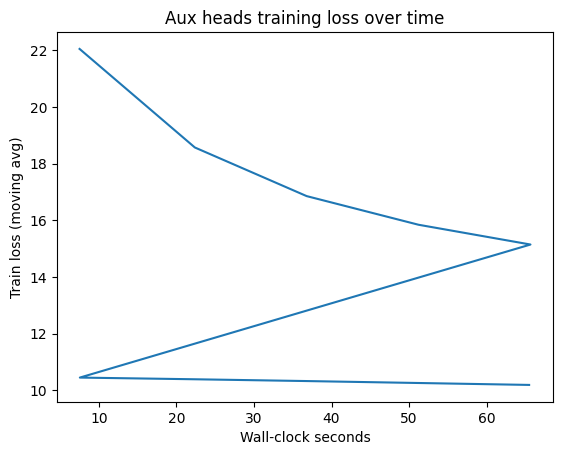

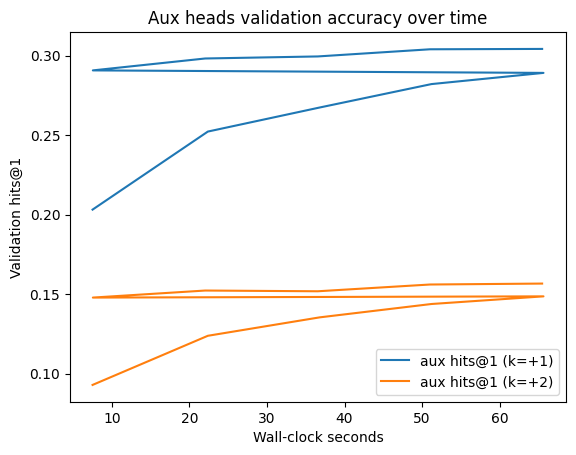

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- time vs train loss ---
plt.figure()
plt.plot(history["time_s"], history["train_loss"])
plt.xlabel("Wall-clock seconds")
plt.ylabel("Train loss (moving avg)")
plt.title("Aux heads training loss over time")
plt.show()

# --- time vs aux hits@1 (k=+1, +2) ---
plt.figure()
plt.plot(history["time_s"], history["val_aux_hits1_k1"], label="aux hits@1 (k=+1)")
plt.plot(history["time_s"], history["val_aux_hits1_k2"], label="aux hits@1 (k=+2)")
plt.xlabel("Wall-clock seconds")
plt.ylabel("Validation hits@1")
plt.title("Aux heads validation accuracy over time")
plt.legend()
plt.show()


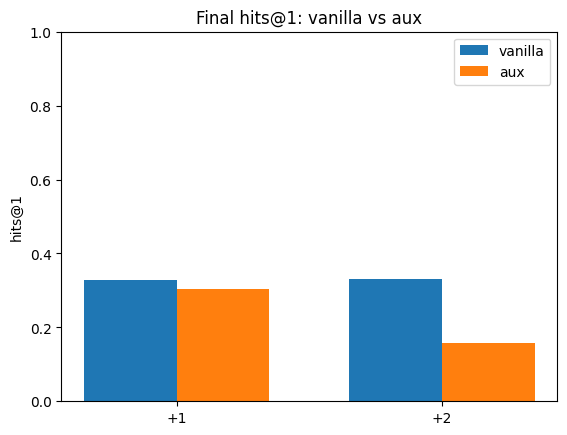

In [ ]:
labels = [f"+{k}" for k in OFFSETS]
van = [base_metrics[k]["hits@1"] for k in OFFSETS]
auxv = [aux_metrics[k]["hits@1"] for k in OFFSETS]

x = np.arange(len(labels))
w = 0.35
plt.figure()
plt.bar(x - w/2, van, width=w, label="vanilla")
plt.bar(x + w/2, auxv, width=w, label="aux")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("hits@1")
plt.title("Final hits@1: vanilla vs aux")
plt.legend()
plt.show()


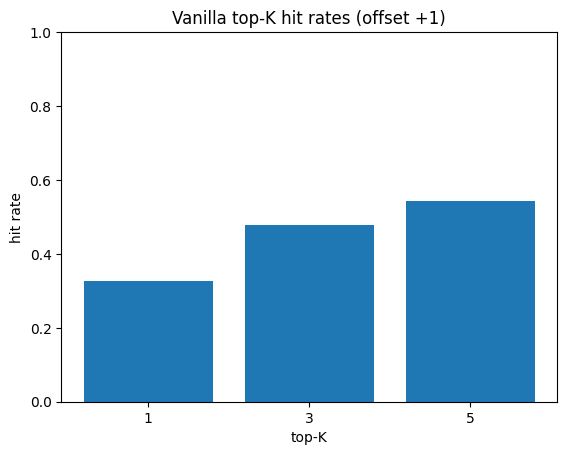

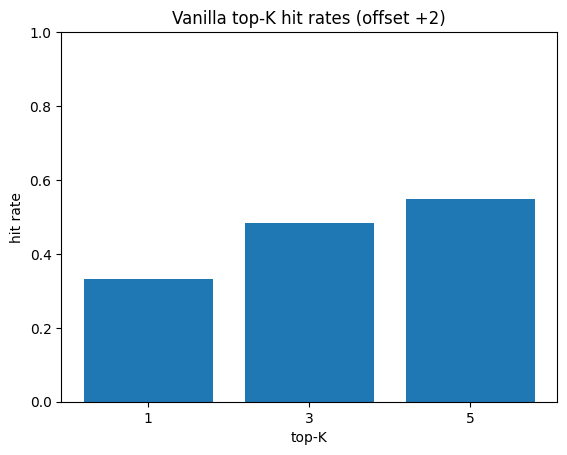

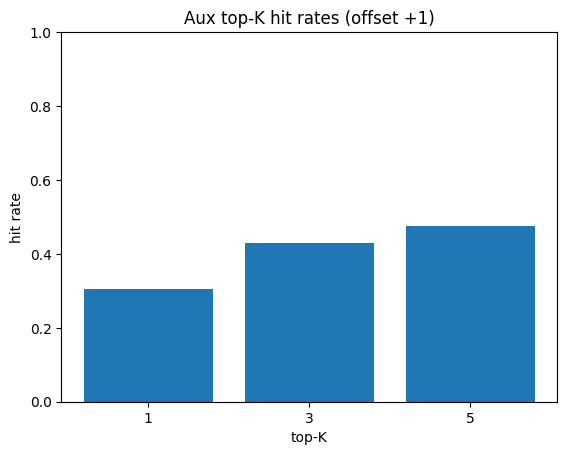

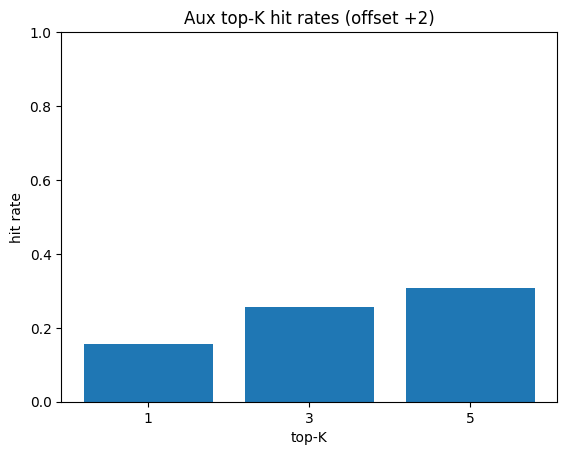

In [ ]:
def plot_topk(model_name, metrics_dict, offsets=OFFSETS):
    ks = [1,3,5]
    for k in offsets:
        vals = [metrics_dict[k][f"hits@{kk}"] for kk in ks]
        plt.figure()
        plt.bar([str(kk) for kk in ks], vals)
        plt.ylim(0, 1)
        plt.xlabel("top-K")
        plt.ylabel("hit rate")
        plt.title(f"{model_name} top-K hit rates (offset +{k})")
        plt.show()

plot_topk("Vanilla", base_metrics, OFFSETS)
plot_topk("Aux", aux_metrics, OFFSETS)


Look at the context aND PREDICTED TOKENS IN THE TOP K TO VERIOFY HOW FAR OFF THE MODEL REALLY WAS.

In [ ]:
import torch

@torch.no_grad()
def show_stepwise_predictions(model, aux, loader, tokenizer, n_show=8, max_ctx_tokens=40, device=device):
    """
    For a few valid positions t, show:
      - CONTEXT up to t
      - GOLD t+1, GOLD t+2
      - VANILLA greedy autoregressive predictions: pred(t+1), then pred(t+2) after appending pred(t+1)
      - AUX heads top-5 for +1 and +2 from the same source hidden state at t.
    """
    model.eval(); aux.eval()
    shown = 0

    for batch in loader:
        inp  = batch.input_ids.to(device)           # (B,T)
        attn = batch.attention_mask.to(device)      # (B,T)
        B, T = inp.shape
        if T <= 2:
            continue

        # 1) Vanilla logits for alignment (for reference if needed)
        out_v = model(input_ids=inp, attention_mask=attn)
        logits_all = out_v.logits  # (B,T,V)

        # 2) Hidden states for aux heads
        H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)
        off = aux(H, attn)  # dict: {1: (logits_+1, mask_+1), 2: (logits_+2, mask_+2)}
        logits_aux1, mask_aux1 = off[1]  # (B,T-1,V), (B,T-1)
        logits_aux2, mask_aux2 = off[2]  # (B,T-2,V), (B,T-2)

        # collect valid source positions t where both +1 and +2 are valid
        # (i.e., t <= T-3 so t+1 and t+2 exist; masks also true)
        valid_mask = torch.zeros((B, T-2), dtype=torch.bool, device=device)
        valid_mask = mask_aux2  # already ensures both positions are valid for +2; +1 is implied for t by construction

        idxs = valid_mask.nonzero(as_tuple=False)  # [(b, t_src)] t_src in [0..T-3]
        if idxs.numel() == 0:
            continue

        # randomize to see variety
        perm = torch.randperm(idxs.size(0), device=device)
        idxs = idxs[perm]

        for b, t_src in idxs:
            b = int(b.item()); t_src = int(t_src.item())

            # --- build human-readable CONTEXT up to t_src ---
            # clip left to last max_ctx_tokens (avoid long contexts)
            left = max(0, t_src - max_ctx_tokens)
            ctx_ids = inp[b, left:t_src]  # tokens strictly before position t_src
            # NOTE: the source hidden state is at position t_src, which corresponds to token at index t_src
            # In GPT-style, to predict next token, we "see" tokens up to and including position t_src
            ctx_with_src = inp[b, left:t_src+1]
            # drop pads for printing
            ctx_print = tokenizer.decode([x for x in ctx_with_src.tolist() if x != tokenizer.pad_token_id])

            # --- GOLD tokens at t+1 and t+2 ---
            gold1_id = int(inp[b, t_src+1].item())
            gold2_id = int(inp[b, t_src+2].item())
            gold1 = tokenizer.decode([gold1_id]) or repr(gold1_id)
            gold2 = tokenizer.decode([gold2_id]) or repr(gold2_id)

            # --- VANILLA greedy autoregressive predictions from exactly this context ---
            #   Step A: predict +1 from context up to t_src
            #   Step B: append pred(+1) and predict +2
            ctx_for_v = ctx_with_src[ctx_with_src != tokenizer.pad_token_id].unsqueeze(0)  # (1, L)
            # predict +1
            out_step1 = model(input_ids=ctx_for_v)
            last_logits1 = out_step1.logits[:, -1, :]  # (1,V)
            pred1_id = int(torch.argmax(last_logits1, dim=-1).item())

            # predict +2 after appending pred1
            ctx_step2 = torch.cat([ctx_for_v, torch.tensor([[pred1_id]], device=device, dtype=ctx_for_v.dtype)], dim=1)
            out_step2 = model(input_ids=ctx_step2)
            last_logits2 = out_step2.logits[:, -1, :]
            pred2_id = int(torch.argmax(last_logits2, dim=-1).item())

            van1 = tokenizer.decode([pred1_id]) or repr(pred1_id)
            van2 = tokenizer.decode([pred2_id]) or repr(pred2_id)

            # --- AUX top-5 for +1 and +2 from same H at t_src ---
            la1 = logits_aux1[b, t_src, :]  # (V,)
            pa1 = torch.softmax(la1, dim=-1)
            top5_p1, top5_i1 = torch.topk(pa1, k=5)
            aux1_top5 = [(tokenizer.decode([i.item()]) or repr(i.item()), float(p.item())) for p,i in zip(top5_p1, top5_i1)]
            aux1_top1 = aux1_top5[0][0]

            la2 = logits_aux2[b, t_src, :]
            pa2 = torch.softmax(la2, dim=-1)
            top5_p2, top5_i2 = torch.topk(pa2, k=5)
            aux2_top5 = [(tokenizer.decode([i.item()]) or repr(i.item()), float(p.item())) for p,i in zip(top5_p2, top5_i2)]
            aux2_top1 = aux2_top5[0][0]

            # flags: whether gold in top5
            gold_in_aux1 = any(int(i.item()) == gold1_id for i in top5_i1)
            gold_in_aux2 = any(int(i.item()) == gold2_id for i in top5_i2)

            print("—"*96)
            print(f"CONTEXT [...t={t_src}] : {ctx_print}")
            print(f"GOLD:  t+1={gold1!r}, t+2={gold2!r}")
            print(f"VANIL: t+1={van1!r}, t+2={van2!r}   (greedy autoregressive)")
            print(f"AUX+1 top5: {[(tok, f'{p:.3f}') for tok,p in aux1_top5]}  gold_in_top5={gold_in_aux1}")
            print(f"AUX+2 top5: {[(tok, f'{p:.3f}') for tok,p in aux2_top5]}  gold_in_top5={gold_in_aux2}")

            shown += 1
            if shown >= n_show:
                return

# Run it:
show_stepwise_predictions(model, aux, val_loader, tokenizer, n_show=8)


————————————————————————————————————————————————————————————————————————————————————————————————
CONTEXT [...t=41] : arus gammarus is a large crustacean , with a body length up to 60 centimetres ( 24 in ) and weighing up to 5 – 6 kilograms ( 11 – 13 lb ) , although
GOLD:  t+1=' the', t+2=' lob'
VANIL: t+1=' it', t+2=' is'   (greedy autoregressive)
AUX+1 top5: [(' it', '0.361'), (' its', '0.127'), (' the', '0.074'), (' this', '0.047'), (' they', '0.018')]  gold_in_top5=True
AUX+2 top5: [(' species', '0.115'), (' are', '0.051'), (' the', '0.027'), (' is', '0.026'), (' it', '0.020')]  gold_in_top5=False
————————————————————————————————————————————————————————————————————————————————————————————————
CONTEXT [...t=70] :  and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms (
GOLD:  t+1=' 13', t+2=' lb'
VANIL: t+1=' 4', t+2='.'   (greedy autoregressive)
AUX+1 top5: [(' 7', '0.164'), (

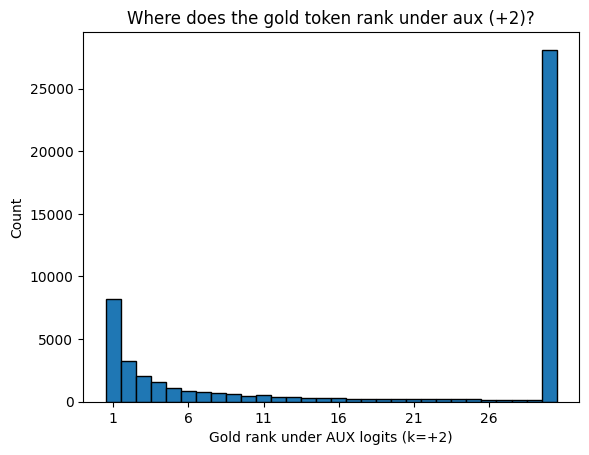

In [ ]:
@torch.no_grad()
def aux_gold_rank_histogram(model, aux, loader, tokenizer, offset=2, max_rank=50, device=device):
    model.eval(); aux.eval()
    ranks = []

    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) <= offset:
            continue

        H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state
        logits_a, mask_a = aux(H, attn)[offset]     # (B,T-k,V),(B,T-k)
        tgt_a = inp[:, offset:]

        B, Tk, V = logits_a.shape
        m = mask_a.bool()
        if not m.any():
            continue

        la = logits_a[m]                           # (N,V)
        gold = tgt_a[m]                            # (N,)
        # rank of gold (1 = best)
        order = torch.argsort(la, dim=-1, descending=True)   # (N,V)
        # find index where gold appears
        eq = (order == gold.unsqueeze(-1))                    # (N,V)
        pos = torch.argmax(eq.int(), dim=-1)                  # (N,)
        ranks.extend((pos + 1).cpu().tolist())

    import matplotlib.pyplot as plt
    import numpy as np
    ranks = np.array(ranks)
    if len(ranks) == 0:
        print("No valid ranks collected.")
        return
    plt.figure()
    bins = np.arange(1, max_rank+2)  # 1..max_rank
    plt.hist(np.clip(ranks, 1, max_rank), bins=bins, edgecolor='k', align='left')
    plt.xlabel("Gold rank under AUX logits (k=+2)")
    plt.ylabel("Count")
    plt.title("Where does the gold token rank under aux (+2)?")
    plt.xticks(range(1, max_rank+1, 5))
    plt.show()

aux_gold_rank_histogram(model, aux, val_loader, tokenizer, offset=2, max_rank=30)


## Count Tokens To Verify Training Size

In [ ]:
def quick_count(dataset, name="dataset"):
    attn = np.array(dataset["attention_mask"])
    total_tokens = attn.size
    total_real_tokens = attn.sum()
    print(f"{name}: total={total_tokens:,} (with pads), real={total_real_tokens:,} (no pads)")

quick_count(tok_train, "train split")
quick_count(tok_val, "val split")


train split: total=9,399,808 (with pads), real=2,297,610 (no pads)
val split: total=962,560 (with pads), real=240,245 (no pads)


## multi head future token predictor with vanilla pretrained head and new future token head

trunk is froze as before. k+1 weights are initialized from gpt2 pretrained head. added a future k+2 head and trained both heads together for future token prediction task. K+2 is initialized randomly as normal.

In [ ]:
# ====== minimal installs ======
!pip -q install transformers datasets torch

# ====== imports ======
import time, numpy as np
import math, torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Dict, Tuple
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ====== data: small & simple (WikiText-2 raw) ======
raw = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad; use EOS

MAX_LEN = 256

def tokenize_fn(ex):
    # Fixed length => no ragged batches; attention_mask marks real tokens.
    return tokenizer(
        ex["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )

tok_train = raw["train"].map(tokenize_fn, batched=True, remove_columns=raw["train"].column_names)
tok_val   = raw["validation"].map(tokenize_fn, batched=True, remove_columns=raw["validation"].column_names)

@dataclass
class CausalBatch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor

def collate(batch):
    return CausalBatch(
        input_ids=torch.tensor([b["input_ids"] for b in batch], dtype=torch.long),
        attention_mask=torch.tensor([b["attention_mask"] for b in batch], dtype=torch.long),
    )

# small slices for speed; increase for better signal
train_loader = DataLoader(tok_train.select(range(4000)), batch_size=8, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(tok_val.select(range(1000)),  batch_size=8, shuffle=False, collate_fn=collate)

# ====== model: load GPT-2, freeze trunk, add auxiliary heads (t+1, t+2) ======
base_name = "gpt2"
cfg = AutoConfig.from_pretrained(base_name, output_hidden_states=False)  # last_hidden_state is sufficient
model = AutoModelForCausalLM.from_pretrained(base_name, config=cfg).to(device)
vocab_size = model.config.vocab_size
hidden_size = model.transformer.wte.embedding_dim  # 768 for gpt2

# freeze all pretrained params
for p in model.parameters():
    p.requires_grad_(False)

OFFSETS = (1, 2)  # drop +3 everywhere

# --- CHANGE 1: make aux heads bias-free so we can copy lm_head exactly ---
class OffsetHeads(nn.Module):
    """
    Simple linear heads that read from the final hidden state at position t
    and predict tokens at offsets t+1, t+2.
    """
    def __init__(self, hidden_size: int, vocab_size: int, offsets=OFFSETS):
        super().__init__()
        self.offsets = list(offsets)
        # bias=False to match GPT-2's lm_head
        self.heads = nn.ModuleDict({str(k): nn.Linear(hidden_size, vocab_size, bias = False) for k in self.offsets})

    def forward(self, H: torch.Tensor, attn_mask: torch.Tensor) -> Dict[int, Tuple[torch.Tensor, torch.Tensor]]:
        """
        H: (B, T, d) final hidden states from GPT-2 transformer
        attn_mask: (B, T)
        Returns dict: k -> (logits_k, mask_k),
          where logits_k shape is (B, T-k, V) aligned to predict x_{t+k} from H_t
        """
        B, T, D = H.shape
        out = {}
        for k in self.offsets:
            head = self.heads[str(k)]
            # valid source positions t: 0..T-k-1
            logits = head(H[:, :-k, :])                     # (B, T-k, V)
            # mask requires both source pos and target pos to be valid:
            mask = (attn_mask[:, :-k] & attn_mask[:, k:])   # (B, T-k)
            out[k] = (logits, mask)
        return out

aux = OffsetHeads(hidden_size, vocab_size, offsets=OFFSETS).to(device)

# --- CHANGE 2: clone the pretrained GPT-2 head weights into our k=+1 aux head ---
# This keeps the GPT-2 trunk and original tied head frozen; we only train our independent aux heads.
with torch.no_grad():
    if "1" in aux.heads:
        aux.heads["1"].weight.copy_(model.lm_head.weight)  # copy weights; now k+1 aux starts from GPT-2's head
    else:
        raise ValueError("OFFSETS must include 1 to initialize k+1 head from pretrained weights.")

# optimizer stays the same: it will update ONLY aux heads (k=+1 cloned, k=+2 random) while trunk remains frozen
optim = torch.optim.AdamW(aux.parameters(), lr=5e-4)

# ====== helpers: alignment, metrics, significance ======
def _aligned_slices_for_k(logits, inp, attn, k):
    """
    Align logits (vanilla) at positions t+k-1 with targets at t+k.
    Returns: logits_k (B, T-k, V), tgt_k (B, T-k), mask_k (B, T-k)
    """
    B, T, V = logits.shape
    assert T > k, "sequence too short for this offset"
    start = k - 1
    logits_k = logits[:, start:-1, :]          # (B, T-k, V)
    tgt_k    = inp[:, k:]                      # (B, T-k)
    mask_k   = attn[:, start:-1] & attn[:, k:] # (B, T-k)
    return logits_k, tgt_k, mask_k

def _compute_topk_metrics(logits, targets, mask, topks=(1,3,5)):
    """
    logits: (B, T, V), targets: (B, T), mask: (B, T)
    Returns dict: {"loss":..., "hits@1":..., "hits@3":..., "hits@5":..., "count":...}
    """
    V = logits.size(-1)
    m = mask.bool().view(-1)
    if m.sum().item() == 0:
        return {"loss": 0.0, "count": 0, **{f"hits@{k}": 0.0 for k in topks}}
    logits_f = logits.reshape(-1, V)[m]
    tgt_f    = targets.reshape(-1)[m]
    loss     = F.cross_entropy(logits_f, tgt_f).item()
    out = {"loss": loss, "count": int(m.sum().item())}
    for k in topks:
        k = min(k, V)
        topk_idx = logits_f.topk(k, dim=-1).indices
        hits = (topk_idx == tgt_f.unsqueeze(-1)).any(dim=-1).float().mean().item()
        out[f"hits@{k}"] = hits
    return out

def _gather_correct_flags(logits, targets, mask):
    """
    Returns boolean vector (N,) of 'was top1 correct' for significance tests.
    """
    V = logits.size(-1)
    m = mask.bool().view(-1)
    if m.sum().item() == 0:
        return np.zeros((0,), dtype=bool)
    logits_f = logits.reshape(-1, V)[m]
    tgt_f    = targets.reshape(-1)[m]
    pred     = logits_f.argmax(-1)
    return (pred == tgt_f).detach().cpu().numpy().astype(bool)

def mcnemar_exact_p(b, c):
    """
    Exact two-sided McNemar via binomial test on discordant pairs (n=b+c).
    Uses log-space to avoid overflow for large n.
    b = count where method A correct and B wrong
    c = count where method B correct and A wrong
    """
    n = b + c
    if n == 0:
        return 1.0

    k_max = min(b, c)  # smaller side for the two-sided tail
    log_half = math.log(0.5)

    # log C(n, k) via lgamma
    def log_comb(n_, k_):
        return math.lgamma(n_ + 1) - math.lgamma(k_ + 1) - math.lgamma(n_ - k_ + 1)

    # accumulate in log-space: tail = sum_{k=0..k_max} C(n,k) * 0.5^n
    logs = [log_comb(n, k) + n * log_half for k in range(k_max + 1)]
    m = max(logs)
    tail = math.exp(m) * sum(math.exp(li - m) for li in logs)

    p_two_sided = min(1.0, 2.0 * tail)
    return p_two_sided


# ====== eval: AUX (frozen heads) ======
@torch.no_grad()
def eval_aux(aux, model, loader, topks=(1,3,5)):
    model.eval(); aux.eval()
    agg = {k: {"loss_sum":0.0, "count":0, **{f"hits@{t}":0.0 for t in topks}} for k in OFFSETS}
    flags = {k: [] for k in OFFSETS}

    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) <= max(OFFSETS):
            continue

        H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)
        out = aux(H, attn)  # dict k -> (logits, mask)

        for k in OFFSETS:
            logits_k, mask_k = out[k]
            tgt_k = inp[:, k:]  # (B, T-k)
            m = _compute_topk_metrics(logits_k, tgt_k, mask_k, topks=topks)
            N = m["count"]
            if N == 0:
                continue
            agg[k]["loss_sum"] += m["loss"] * N
            agg[k]["count"]    += N
            for t in topks:
                agg[k][f"hits@{t}"] += m[f"hits@{t}"] * N
            flags[k].append(_gather_correct_flags(logits_k, tgt_k, mask_k))

    res = {}
    for k in OFFSETS:
        N = max(1, agg[k]["count"])
        res[k] = {
            "loss": agg[k]["loss_sum"] / N,
            **{f"hits@{t}": agg[k][f"hits@{t}"] / N for t in topks},
            "count": agg[k]["count"]
        }
    flags = {k: (np.concatenate(flags[k]) if len(flags[k]) else np.zeros((0,), dtype=bool)) for k in OFFSETS}
    return res, flags

# ====== eval: VANILLA (teacher forced @ offsets) ======
@torch.no_grad()
def eval_vanilla(model, loader, topks=(1,3,5)):
    model.eval()
    agg = {k: {"loss_sum":0.0, "count":0, **{f"hits@{t}":0.0 for t in topks}} for k in OFFSETS}
    flags = {k: [] for k in OFFSETS}

    for batch in loader:
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)
        if inp.size(1) <= max(OFFSETS):
            continue
        out  = model(input_ids=inp, attention_mask=attn)
        logits = out.logits  # (B,T,V)

        for k in OFFSETS:
            logits_k, tgt_k, mask_k = _aligned_slices_for_k(logits, inp, attn, k)
            m = _compute_topk_metrics(logits_k, tgt_k, mask_k, topks=topks)
            N = m["count"]
            if N == 0:
                continue
            agg[k]["loss_sum"] += m["loss"] * N
            agg[k]["count"]    += N
            for t in topks:
                agg[k][f"hits@{t}"] += m[f"hits@{t}"] * N
            flags[k].append(_gather_correct_flags(logits_k, tgt_k, mask_k))

    res = {}
    for k in OFFSETS:
        N = max(1, agg[k]["count"])
        res[k] = {
            "loss": agg[k]["loss_sum"] / N,
            **{f"hits@{t}": agg[k][f"hits@{t}"] / N for t in topks},
            "count": agg[k]["count"]
        }
    flags = {k: (np.concatenate(flags[k]) if len(flags[k]) else np.zeros((0,), dtype=bool)) for k in OFFSETS}
    return res, flags

# ====== training loop: train ONLY the aux heads ======
history = {"time_s": [], "step": [], "train_loss": [], "val_aux_hits1_k1": [], "val_aux_hits1_k2": []}

def train_epoch(model, aux, loader, optim, val_loader=None, log_every=100):
    model.eval(); aux.train()
    t0 = time.perf_counter()
    running = 0.0
    steps_done = 0

    for step_idx, batch in enumerate(loader, 1):
        inp  = batch.input_ids.to(device)
        attn = batch.attention_mask.to(device)

        with torch.no_grad():
            H = model.transformer(input_ids=inp, attention_mask=attn).last_hidden_state  # (B,T,d)

        off = aux(H, attn)  # dict: k -> (logits_k, mask_k)

        # collect per-offset losses
        per_losses = []
        for k in OFFSETS:
            logits_k, mask_k = off[k]          # (B,T-k,V), (B,T-k)
            tgt_k = inp[:, k:]                 # (B,T-k)
            V = logits_k.size(-1)
            m = mask_k.bool().view(-1)
            if m.any():
                logits_f = logits_k.reshape(-1, V)[m]
                tgt_f    = tgt_k.reshape(-1)[m]
                per_losses.append(F.cross_entropy(logits_f, tgt_f))

        # if no valid positions this batch, skip update
        if len(per_losses) == 0:
            # still do periodic logging snapshots
            if step_idx % log_every == 0 and val_loader is not None:
                wall = time.perf_counter() - t0
                aux_metrics_snap, _ = eval_aux(aux, model, val_loader, topks=(1,))
                h1 = aux_metrics_snap[1]["hits@1"]; h2 = aux_metrics_snap[2]["hits@1"]
                history["time_s"].append(wall)
                history["step"].append(steps_done)
                history["train_loss"].append(running / max(1, steps_done))
                history["val_aux_hits1_k1"].append(h1)
                history["val_aux_hits1_k2"].append(h2)
                print(f"step {step_idx:4d} | (skip batch) train_loss={running/max(1,steps_done):.3f} | aux hits@1: +1={h1:.3f} +2={h2:.3f}")
            continue

        total = torch.stack(per_losses).sum()   # Tensor
        optim.zero_grad(set_to_none=True)
        total.backward()
        optim.step()

        running += float(total.item())
        steps_done += 1

        if step_idx % log_every == 0:
            wall = time.perf_counter() - t0
            if val_loader is not None:
                aux_metrics_snap, _ = eval_aux(aux, model, val_loader, topks=(1,))
                h1 = aux_metrics_snap[1]["hits@1"]; h2 = aux_metrics_snap[2]["hits@1"]
            else:
                h1 = h2 = float('nan')
            history["time_s"].append(wall)
            history["step"].append(steps_done)
            history["train_loss"].append(running / steps_done)
            history["val_aux_hits1_k1"].append(h1)
            history["val_aux_hits1_k2"].append(h2)
            print(f"step {step_idx:4d} | train_loss={running/steps_done:.3f} | aux hits@1: +1={h1:.3f} +2={h2:.3f}")

    return running / max(1, steps_done)

# ====== run: baseline -> train -> compare ======
print(">>> Baseline (vanilla GPT-2)")
base_metrics, base_flags = eval_vanilla(model, val_loader, topks=(1,3,5))
for k in OFFSETS:
    bm = base_metrics[k]
    print(f"vanilla k=+{k}: hits@1={bm['hits@1']:.3f} hits@3={bm['hits@3']:.3f} hits@5={bm['hits@5']:.3f} loss={bm['loss']:.3f} N={bm['count']}")

print("\n>>> Train aux heads (frozen trunk)")
EPOCHS = 2
for e in range(1, EPOCHS+1):
    tr_loss = train_epoch(model, aux, train_loader, optim, val_loader=val_loader, log_every=100)
    aux_metrics, aux_flags = eval_aux(aux, model, val_loader, topks=(1,3,5))
    print(f"[epoch {e}] train_loss={tr_loss:.3f} | "
          f"aux +1 hits@1={aux_metrics[1]['hits@1']:.3f} +2 hits@1={aux_metrics[2]['hits@1']:.3f}")

print("\n>>> Final comparison (hits@1 / loss)")
aux_metrics, aux_flags = eval_aux(aux, model, val_loader, topks=(1,3,5))
for k in OFFSETS:
    print(f"k=+{k} | AUX hits@1={aux_metrics[k]['hits@1']:.3f} (loss={aux_metrics[k]['loss']:.3f})"
          f"  vs  VANILLA hits@1={base_metrics[k]['hits@1']:.3f} (loss={base_metrics[k]['loss']:.3f})")

print("\n>>> Significance (McNemar exact, two-sided) for top1 correctness")
for k in OFFSETS:
    v = base_flags[k]
    a = aux_flags[k]
    # align lengths (should match; just in case)
    n = min(len(v), len(a))
    v, a = v[:n], a[:n]
    # counts
    both_correct = np.sum((v == True) & (a == True))
    v_only = np.sum((v == True) & (a == False))
    a_only = np.sum((v == False) & (a == True))
    both_wrong = np.sum((v == False) & (a == False))
    p = mcnemar_exact_p(v_only, a_only)
    print(f"k=+{k}: table=[[{both_correct}, {v_only}], [{a_only}, {both_wrong}]]  p={p:.4g}")


Device: cuda


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

>>> Baseline (vanilla GPT-2)
vanilla k=+1: hits@1=0.328 hits@3=0.478 hits@5=0.543 loss=3.893 N=52902
vanilla k=+2: hits@1=0.331 hits@3=0.483 hits@5=0.549 loss=3.847 N=52258

>>> Train aux heads (frozen trunk)
step  100 | train_loss=14.961 | aux hits@1: +1=0.352 +2=0.094
step  200 | train_loss=13.370 | aux hits@1: +1=0.357 +2=0.123
step  300 | train_loss=12.612 | aux hits@1: +1=0.362 +2=0.137
step  400 | train_loss=12.142 | aux hits@1: +1=0.361 +2=0.141
step  500 | train_loss=11.819 | aux hits@1: +1=0.363 +2=0.148
[epoch 1] train_loss=11.819 | aux +1 hits@1=0.363 +2 hits@1=0.148
step  100 | train_loss=8.932 | aux hits@1: +1=0.365 +2=0.151
step  200 | train_loss=8.942 | aux hits@1: +1=0.365 +2=0.151
step  300 | train_loss=8.940 | aux hits@1: +1=0.364 +2=0.154
step  400 | train_loss=8.936 | aux hits@1: +1=0.367 +2=0.157
step  500 | train_loss=8.927 | aux hits@1: +1=0.363 +2=0.156
[epoch 2] train_loss=8.927 | aux +1 hits@1=0.363 +2 hits@1=0.156

>>> Final comparison (hits@1 / loss)
k=+1 | 